In [1]:
import os
import pickle

import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn

from models.forward import ForwardDiffusion
from models.reverse import ReverseDiffusion

%load_ext autoreload
%autoreload 2

In [2]:
def transform_CHW(img):
    img = img.squeeze().cpu()
    img -= img.min()
    img /= img.max()
    return img.permute(1, 2, 0)

In [3]:
device = torch.device('cuda:0')

## Data

In [4]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

batch_size = 16

trucks = torch.load('trucks.pt').float() * 2 / 255 - 1
trucks_dl = DataLoader(trucks, batch_size=batch_size, shuffle=True)

## Diffusion Processes

In [5]:
T = 1000

forward = ForwardDiffusion(
    noise_param=0.1, 
    T=T, 
    schedule='cosine', 
    device=device
)

reverse = ReverseDiffusion(
    forward_process=forward, 
    time_embedding_dim=32, 
    time_n=4096, 
    device=device
)

print(f'{sum(p.numel() for p in reverse.parameters() if p.requires_grad)} parameters')

642425 parameters


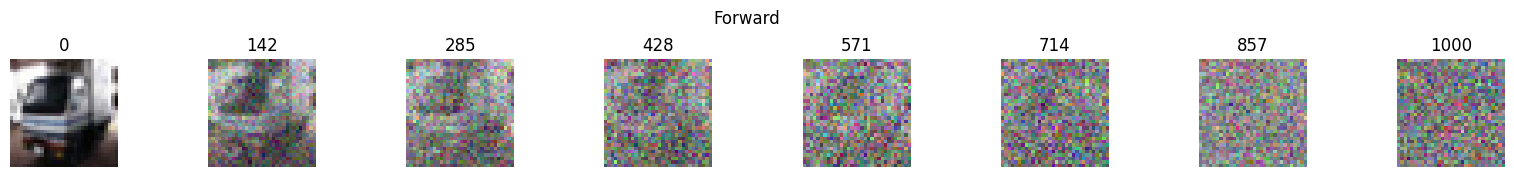

In [6]:
fig, axs = plt.subplots(1, 8, figsize=(16, 2))

fig.suptitle('Forward')
fig.tight_layout()

x = trucks[torch.randint(0, len(trucks), (1, ))].to(device)
times = torch.linspace(0, T, 8, dtype=torch.long)

for i, t in enumerate(times):
    noised, eps = forward(x, t)
    axs[i].axis('off')
    axs[i].set_title(f'{t}')
    axs[i].imshow(transform_CHW(noised).cpu())

## Training

In [7]:
optimizer = torch.optim.Adam(reverse.parameters(), lr=0.0001)
L1Loss = nn.MSELoss()

losses = []

................................................................

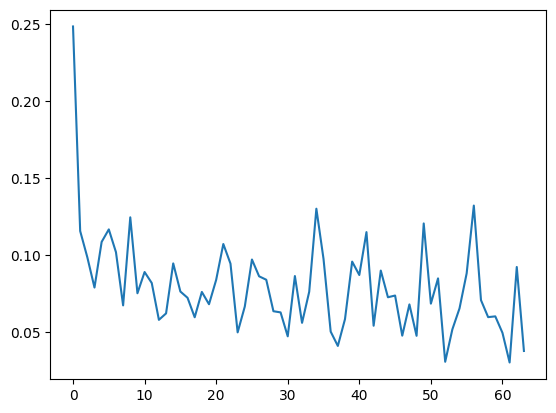

In [8]:
reverse.train()
for epoch in range(64):
    for x_0 in trucks_dl:
        
        x_0 = x_0.to(device)
        
        t = torch.randint(1, T+1, (x_0.shape[0], ), device=device)

        with torch.no_grad():
            x_t, eps = forward(x_0, t.view(x_0.shape[0], 1, 1, 1))

        eps_hat = reverse.step(x_t, t)

        loss = L1Loss(eps, eps_hat)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

    losses.append(loss.detach().cpu())
    
    print('.', end='')

torch.save(reverse.state_dict(), './models/reverse.pt')
plt.plot([loss.cpu() for loss in losses])

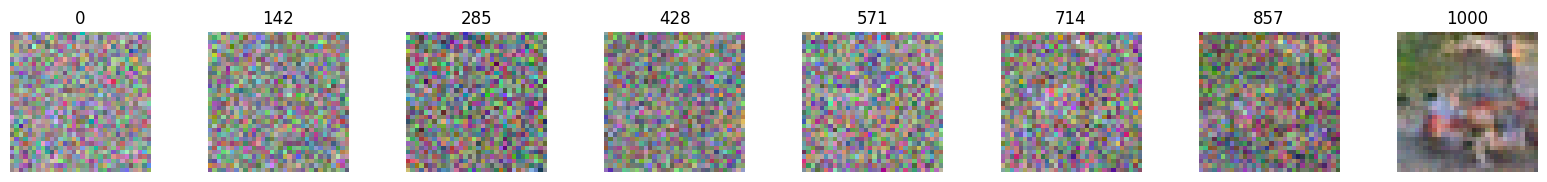

In [48]:
x_T = torch.randn(3, 32, 32, device=device)

with torch.no_grad():
    reverse.eval()
    imgs = reverse(x_T.unsqueeze(0), True)

times = torch.linspace(0, T, 8, dtype=torch.long)

fig, axs = plt.subplots(1, len(times), figsize=(16, 2))
fig.tight_layout()

for i, t in enumerate(times):
    axs[i].axis('off')
    axs[i].set_title(f'{t}')
    axs[i].imshow(transform_CHW(imgs[t].squeeze()).cpu())